## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 ybs  staff  1312 Aug 25 16:59 CroppedYaleB
drwx------@ 44 ybs  staff  1408 Aug 24 15:37 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [5]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [4]:
# Load ORL dataset.
X_orl, Y_orl = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))

# Load Extended YaleB dataset.
X_yaleB, Y_yaleB = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yaleB.shape, Y_yaleB.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [4]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """ 
    Load AR dataset to numpy array.
    
    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    
    for fname in os.listdir(root):
        
        if not fname.endswith('.bmp'):
            continue
        
        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50
        
        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey
        
        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])
   
        # TODO: preprocessing.
        
        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))
        
        # collect data and label.
        images.append(img)
        labels.append(label)
        
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    
    return images, labels

---------------------------

## 2. Noise Production

### 2.1 Salt and Pepper Noise

In [7]:
# Parameterised Salt and Pepper Noise Function
def add_saltpepper_noise(V_hat, p=0, r=0, random_state=None):
    """
    Add parameterised noise to the dataset
    
    Args:
        V_hat: Clean data matrix (pixels × images)
        p: Ratio of pixel corruption (noise level)
        r: Ratio of corrupted pixels that become white (255)
        random_state: Random seed for reproducibility
    
    Returns:
        V: Noisy data matrix
        noise_mask: Binary mask showing which pixels were corrupted
    """
    rng = np.random.RandomState(random_state)
    
    V = V_hat.copy()
    
    # Create noise mask: p of pixels will be corrupted
    total_pixels = V.size
    num_corrupt = int(p * total_pixels)
    flat_indices = rng.choice(total_pixels, size=num_corrupt, replace=False)
    noise_mask = np.zeros(V.shape, dtype=bool)
    noise_mask.flat[flat_indices] = True
    
    # r of corrupted pixels will become white
    num_white = int(r * num_corrupt)
    white_indices = rng.choice(num_corrupt, size=num_white, replace=False)
    
    # Create white/black mask for corrupted pixels
    white_pixels = np.zeros(V.shape, dtype=bool)
    white_pixels.flat[flat_indices[white_indices]] = True
    
    # Apply noise: corrupted pixels become either white (255) or black (0)
    V[noise_mask & white_pixels] = 255  # White noise
    V[noise_mask & ~white_pixels] = 0    # Black noise
    
    return V, noise_mask

In [13]:
import matplotlib.pyplot as plt
# Comparing images
def compare_images(V_hat, V_noise, num_images=1):
    img_size = [i//3 for i in (92, 112)]

    fig, axes = plt.subplots(num_images, 2, figsize=(8, 3*num_images))

    if num_images == 1:
        axes = axes.reshape(1, -1) 

    for ind in range(num_images):
        axes[ind, 0].imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
        axes[ind, 0].set_title(f'Image {ind+1} (Original)')
        axes[ind, 0].axis('off')
        
        # Noisy image
        axes[ind, 1].imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
        axes[ind, 1].set_title(f'Image {ind+1} (Reconstructed)')
        axes[ind, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


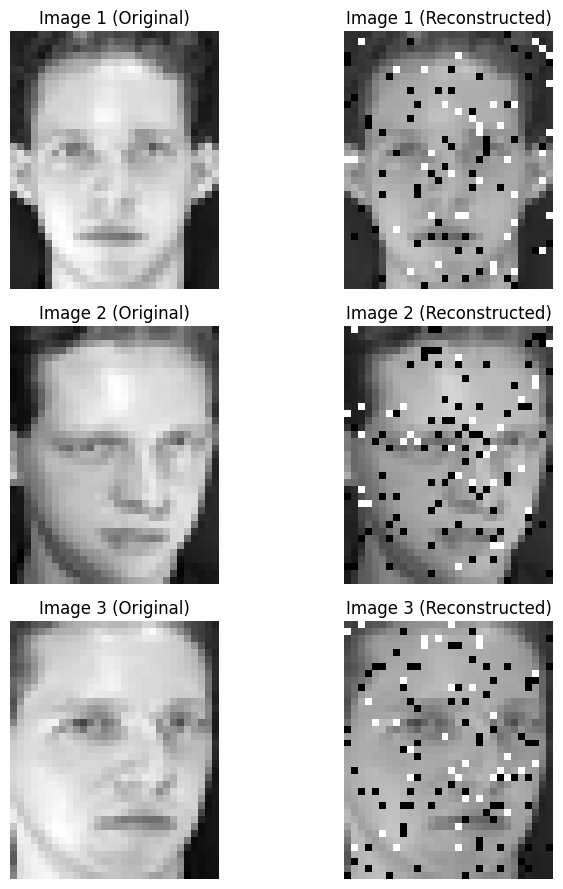

In [25]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise, noise_mask = add_saltpepper_noise(V_hat, p=0.1, r=0.3, random_state=42)

# Compare images
compare_images(V_hat, V_noise, num_images=3)

### 2.2 Gaussian Noise

In [ ]:
# Add Gaussian Noise function here

---------------------------


## 3. Matrix Facorisation

### 3.1 NMF

In [20]:
# NMF function
# Step 1. Initialize dictionary and coefficient matrices
def initialise_matrices(V, k, random_state=None):
    """
    Initialize the W (basis dictionary) and H (coefficient) matrices with random non-negative values
    
    Args:
        V: Input data matrix (m × n)
        k: Number of components 
        random_state: Random seed for reproducibility
    
    Returns:
        W: Initial basis matrix (m × k)
        H: Initial coefficient matrix (k × n)
    """
    m, n = V.shape
    
    # Initialize W and H with random positive values
    rng = np.random.RandomState(random_state)
    W = rng.rand(m, k)
    H = rng.rand(k, n)
    
    return W, H

W_init, H_init = initialise_matrices(V_noise, k=10, random_state=42)
print(f"V shape: {V_noise.shape}")
print(f"W shape: {W_init.shape}")
print(f"H shape: {H_init.shape}")

V shape: (1110, 400)
W shape: (1110, 10)
H shape: (10, 400)


In [21]:
# Step 2. Set update rules for W and H
def H_update(V, W, H):
    """
    Multiplicative Update Rules to solve for H by setting fixed W
    
    H_new = H_old*(W^T*V/W^T*W*H_old) 
    
    Args:
        V: Input data matrix (m × n)
        W: Current basis matrix (m × k)
        H: Current coefficient matrix (k × n)
    
    Returns:
        H_new: Updated coefficient matrix
    """
    # Compute numerator: W^T*V
    numerator = np.dot(np.transpose(W), V)
    
    # Compute denominator: W^T*W*H_old
    denominator = np.dot(np.dot(np.transpose(W), W), H)
    
    # Multiplicative update
    H_new = H * (numerator / denominator)
    
    return H_new
    
def W_update(V, W, H):
    """
    Multiplicative Update Rules to solve for W by setting fixed H
    
    W_new = W_old*(V*H^T/W_old*H*H^T) 
    
    Args:
        V: Input data matrix (m × n)
        W: Current basis matrix (m × k)
        H: Current coefficient matrix (k × n)
    
    Returns:
        W_new: Updated dictionary matrix
    """
    # Compute numerator: V*H^T
    numerator = np.dot(V, np.transpose(H))
    
    # Compute denominator: W_old*H*H^T
    denominator = np.dot(np.dot(W, H), np.transpose(H))
    
    # Multiplicative update
    W_new = W * (numerator / denominator)
    
    return W_new

In [27]:
# Step 3. Optimisation iteration
def optimisation(V, k, max_iter=1000, tol=1e-6, verbose=True, random_state=None):
    """
    Complete optimisation process
    
    Args:
        V: Input data matrix (m × n)
        k: Number of components
        max_iter: Maximum number of iterations
        tol: Convergence tolerance
        random_state: Random seed for initialization
    
    Returns:
        W: Basis matrix (m × k)
        H: Coefficient matrix (k × n)
        errors: List of reconstruction errors at each iteration
    """
     # Initialise matrices
    W, H = initialise_matrices(V, k, random_state)
    
    # Main optimization loop
    for iteration in range(max_iter):
        H_new = H_update(V, W, H)

        # Update W
        W_new = W_update(V, W, H_new)

        # Calculate error
        error_H = np.sqrt(np.sum((H_new-H)**2, axis=(0,1)))/H.size
        error_W = np.sqrt(np.sum((W_new-W)**2, axis=(0,1)))/W.size
        
        # Check convergence
        if error_H < tol and error_W < tol:
            if verbose:
                print(f"Converged at iteration {iteration+1}")
            break
        
        # Print progress every 100 iterations
        if verbose and (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}: Error H = {error_H:.6f},  Error W = {error_W:.6f}")

        H = H_new
        W = W_new
    
    
    return W, H
    

In [30]:
# Step 4. Applying NMF
print('==> Apply NMF ...')
W_final, H_final = optimisation(V_noise, k=40, max_iter=5000, tol=0.00001, verbose=True, random_state=42)
print('W.shape={}, H.shape={}'.format(W_final.shape, H_final.shape))

==> Apply NMF ...
Iteration 100: Error H = 0.000271,  Error W = 0.000017
Iteration 200: Error H = 0.000123,  Error W = 0.000007
Iteration 300: Error H = 0.000075,  Error W = 0.000004
Iteration 400: Error H = 0.000052,  Error W = 0.000003
Iteration 500: Error H = 0.000040,  Error W = 0.000002
Iteration 600: Error H = 0.000033,  Error W = 0.000002
Iteration 700: Error H = 0.000029,  Error W = 0.000001
Iteration 800: Error H = 0.000026,  Error W = 0.000001
Iteration 900: Error H = 0.000023,  Error W = 0.000001
Iteration 1000: Error H = 0.000021,  Error W = 0.000001
Iteration 1100: Error H = 0.000019,  Error W = 0.000001
Iteration 1200: Error H = 0.000018,  Error W = 0.000001
Iteration 1300: Error H = 0.000016,  Error W = 0.000001
Iteration 1400: Error H = 0.000015,  Error W = 0.000001
Iteration 1500: Error H = 0.000014,  Error W = 0.000001
Iteration 1600: Error H = 0.000013,  Error W = 0.000001
Iteration 1700: Error H = 0.000012,  Error W = 0.000001
Iteration 1800: Error H = 0.000011,  Er

### 3.2 Other NMF Variant (Change to the selected algo name)

In [ ]:
# Other NMF function

---------------------------


## 4. Evaluation Metrics


### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [6]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise = np.random.rand(*V_hat.shape) * 40
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
from sklearn.decomposition import NMF
model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
W = model.fit_transform(V)
H = model.components_
print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE))

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


<Figure size 1000x300 with 3 Axes>

==> Apply NMF ...
W.shape=(1110, 40), H.shape=(40, 400)
==> Evaluate RRE ...
RRE = 0.22688415691467015


### 4.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [7]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5875 (0.7431)
